In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import r2_score

import sys
sys.path.insert(0, os.path.abspath('../Libraries'))
import countries
from countries import get_alpha_2_list, get_alpha_3_list

In [3]:
tsv_file='../Datasets/tesem220_tabular.tsv'
 
df=pd.read_table(tsv_file,sep='\t')
df

,"freq,geo\TIME_PERIOD",2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"A,AT",83.00,82.90,82.40,81.70,79.90,80.40,74.80,74.80,74.60,74.3,73.90,72.00,72.1,71.7,71.2,70.50,70.10
1,"A,BE",85.20,84.90,85.30,85.50,92.10,91.00,90.70,91.90,98.10,97.6,96.90,95.80,95.8,93.8,93.0,92.40,91.60
2,"A,BG",:,:,:,76.70,81.70,80.90,81.60,81.60,81.60,81.6,81.60,81.60,82.0,82.4,82.4,82.40,82.40
3,"A,CH",77.70,77.40,77.60,78.90,78.50,78.50,78.50,78.20,78.50,78.3,78.70,78.30,77.1,77.2,77.6,78.90,80.10
4,"A,CY",62.70,62.50,62.40,:,:,:,:,:,:,64.3,:,:,64.2,64.0,64.4,64.40,64.10
5,"A,CZ",65.70,63.50,59.90,59.60,71.30,71.40,71.70,71.60,71.60,71.7,71.80,72.00,72.3,72.5,72.7,72.80,70.80
6,"A,DE",75.00,75.60,74.80,74.50,75.20,73.50,73.30,73.30,73.00,73.1,73.10,73.20,73.3,73.2,73.2,73.00,72.80
7,"A,DK",91.20,90.60,89.50,88.60,88.80,89.20,88.70,89.40,89.40,89.6,89.60,89.80,89.9,89.3,88.4,87.90,87.20
8,"A,EA19",78.8,78.9,76.9,77.4,77.7,76.8,76.8,76.8,77.1,77.1,77.0,76.8,76.6,76.4,75.8,75.4,75.9
9,"A,EE",64.30,63.50,63.00,62.60,61.90,62.70,63.50,64.30,63.70,63.7,62.90,62.90,62.9,61.5,62.2,62.50,69.30


In [4]:
# Clean the dataset

# Replace ":" with NaN
df_cleaned = df.copy()
for index, row in df_cleaned.iterrows():
    for column in df_cleaned.columns[1:]:
        try:
            row[column] = float(row[column])
        except:
            df_cleaned.at[index, column] = np.NaN


# If there are 3 or less consecutive missing values, use Linear Interpolation to fill the missing values
# If there are more than 3 consecutive missing values, drop the row
df_cleaned.interpolate(method='linear', inplace=True, limit=3)
df_cleaned.dropna(inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

df_cleaned.rename(columns={'freq,geo\TIME_PERIOD': 'COUNTRY'}, inplace=True)
df_cleaned.rename(columns=lambda x: int(x.strip()) if x != "COUNTRY" else x, inplace=True)
df_cleaned['COUNTRY'] = df_cleaned['COUNTRY'].str.split(',').str[1]

for column in df_cleaned.columns[1:]:
    df_cleaned[column] = df_cleaned[column].astype(float)
df_cleaned

,COUNTRY,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AT,83.0,82.9,82.4,81.7,79.9,80.4,74.8,74.8,74.6,74.3,73.9,72.0,72.1,71.7,71.2,70.5,70.1
1,BE,85.2,84.9,85.3,85.5,92.1,91.0,90.7,91.9,98.1,97.6,96.9,95.8,95.8,93.8,93.0,92.4,91.6
2,CH,77.7,77.4,77.6,78.9,78.5,78.5,78.5,78.2,78.5,78.3,78.7,78.3,77.1,77.2,77.6,78.9,80.1
3,CZ,65.7,63.5,59.9,59.6,71.3,71.4,71.7,71.6,71.6,71.7,71.8,72.0,72.3,72.5,72.7,72.8,70.8
4,DE,75.0,75.6,74.8,74.5,75.2,73.5,73.3,73.3,73.0,73.1,73.1,73.2,73.3,73.2,73.2,73.0,72.8
5,DK,91.2,90.6,89.5,88.6,88.8,89.2,88.7,89.4,89.4,89.6,89.6,89.8,89.9,89.3,88.4,87.9,87.2
6,EA19,78.8,78.9,76.9,77.4,77.7,76.8,76.8,76.8,77.1,77.1,77.0,76.8,76.6,76.4,75.8,75.4,75.9
7,EE,64.3,63.5,63.0,62.6,61.9,62.7,63.5,64.3,63.7,63.7,62.9,62.9,62.9,61.5,62.2,62.5,69.3
8,EL,55.4,56.4,59.1,65.5,65.4,51.5,56.8,50.7,50.6,50.5,50.3,52.5,52.6,52.6,52.3,55.8,53.7
9,ES,80.2,80.3,81.5,81.2,80.6,82.6,82.7,82.8,81.7,81.7,81.2,81.1,81.1,81.9,82.0,80.5,82.1


In [5]:
# Get only the countries in the EU
df_eu = df_cleaned[df_cleaned['COUNTRY'].isin(get_alpha_2_list())]
df_eu.reset_index(drop=True, inplace=True)
df_eu.to_csv('../Datasets/cleaned_unemploymentTaxRateDataset.csv', index=False)
df_eu

,COUNTRY,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AT,83.0,82.9,82.4,81.7,79.9,80.4,74.8,74.8,74.6,74.3,73.9,72.0,72.1,71.7,71.2,70.5,70.1
1,BE,85.2,84.9,85.3,85.5,92.1,91.0,90.7,91.9,98.1,97.6,96.9,95.8,95.8,93.8,93.0,92.4,91.6
2,CZ,65.7,63.5,59.9,59.6,71.3,71.4,71.7,71.6,71.6,71.7,71.8,72.0,72.3,72.5,72.7,72.8,70.8
3,DE,75.0,75.6,74.8,74.5,75.2,73.5,73.3,73.3,73.0,73.1,73.1,73.2,73.3,73.2,73.2,73.0,72.8
4,DK,91.2,90.6,89.5,88.6,88.8,89.2,88.7,89.4,89.4,89.6,89.6,89.8,89.9,89.3,88.4,87.9,87.2
5,EE,64.3,63.5,63.0,62.6,61.9,62.7,63.5,64.3,63.7,63.7,62.9,62.9,62.9,61.5,62.2,62.5,69.3
6,ES,80.2,80.3,81.5,81.2,80.6,82.6,82.7,82.8,81.7,81.7,81.2,81.1,81.1,81.9,82.0,80.5,82.1
7,FI,77.8,76.3,74.0,73.1,72.1,72.3,72.3,75.0,75.6,81.7,79.2,78.3,74.4,73.9,73.4,73.1,72.4
8,FR,81.6,80.8,77.4,77.2,77.2,76.9,77.4,77.3,77.3,77.4,76.5,76.5,75.8,75.1,72.6,72.2,72.7
9,HU,62.4,68.4,71.6,71.6,72.2,79.9,79.6,79.5,78.8,78.6,78.4,78.1,78.5,78.5,77.1,76.4,73.3


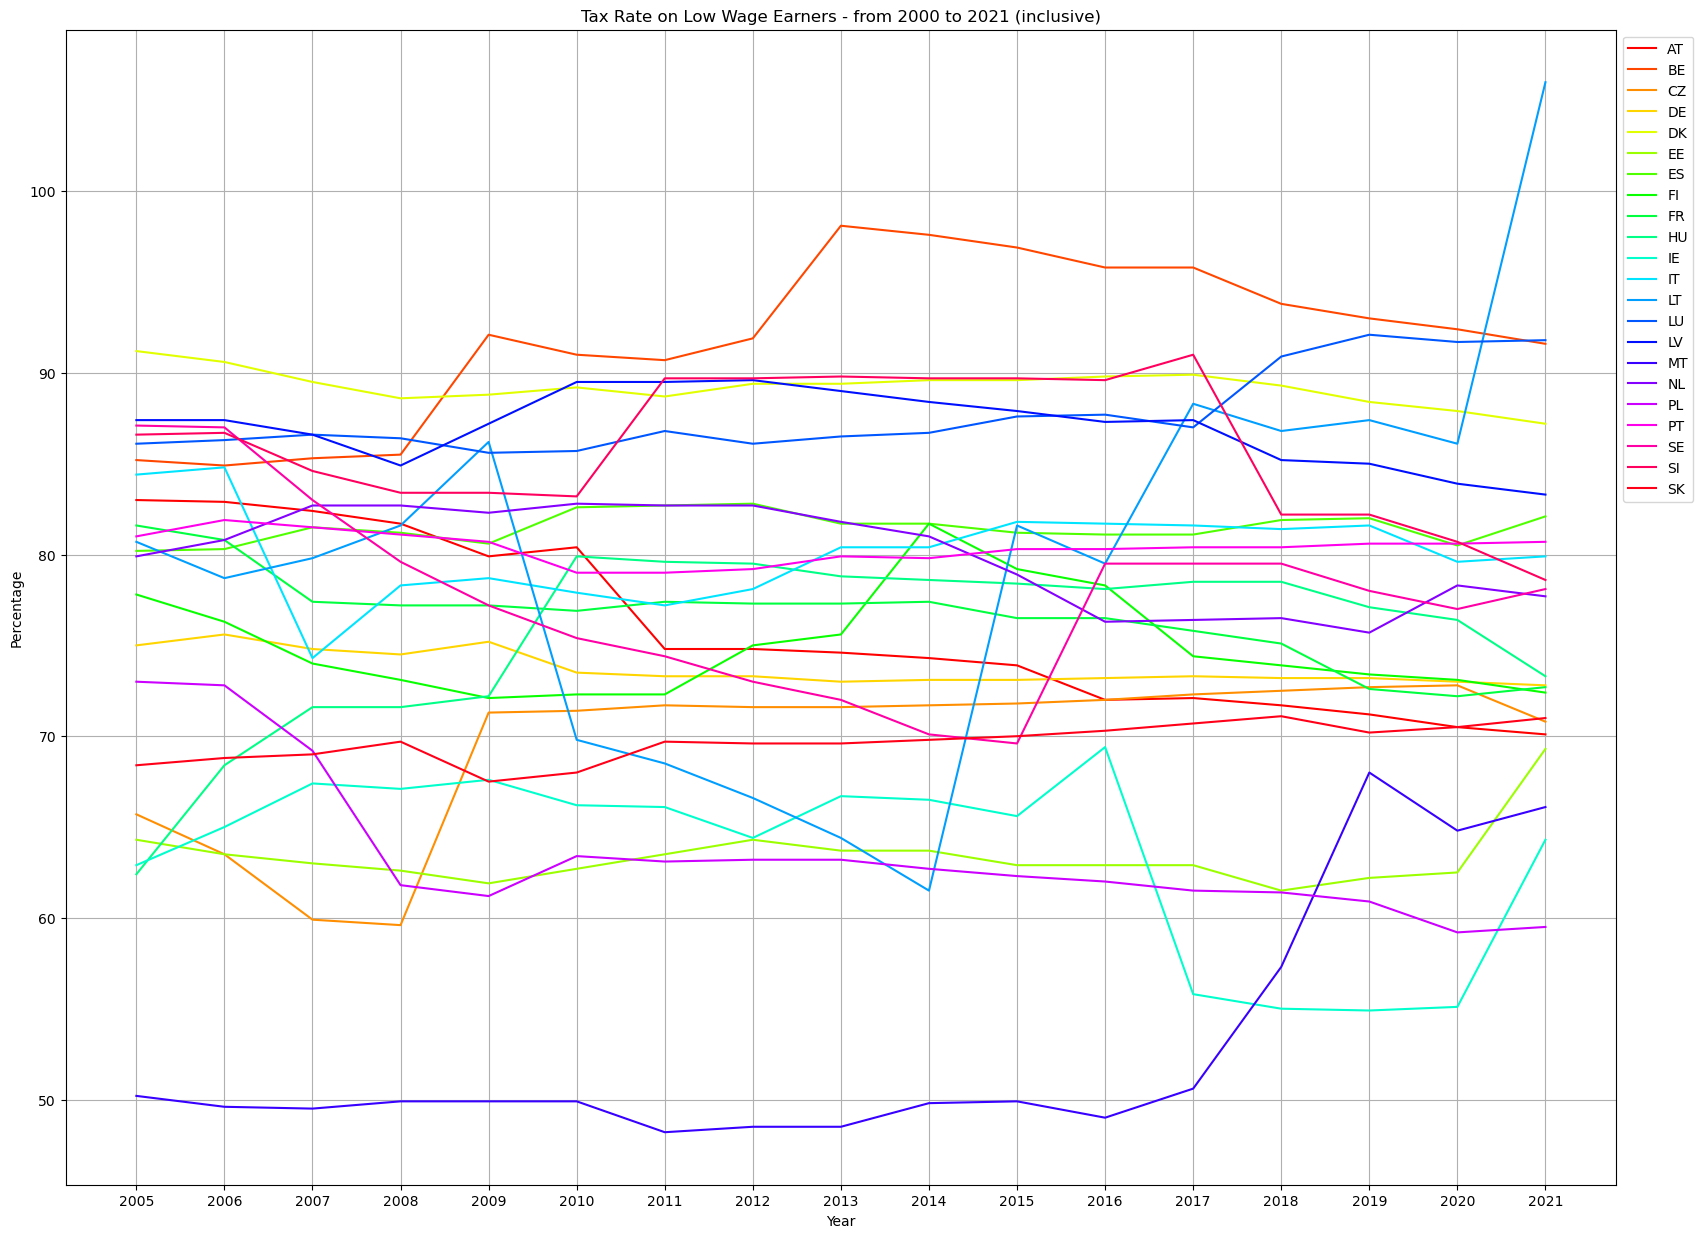

In [6]:
# Plot the tax rate for each country
plt.figure(figsize=(20, 15))

colors = plt.cm.hsv(np.linspace(0, 1, df_eu.shape[0]))
country_codes = df_eu['COUNTRY']
years = df_eu.keys()[1:]
years_xticks = [int(year) for year in years]

for i in range(len(country_codes)):
    country_code = country_codes[i]
    # Plot years to Value
    plt.plot(years, df_eu.loc[i, years], color=colors[i], label=country_code)

plt.grid()
plt.xticks(years_xticks)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel('Year') 
plt.ylabel('Percentage')
plt.title("Tax Rate on Low Wage Earners - from 2000 to 2021 (inclusive)")
plt.show()

In [7]:
# Get the mean unemployment tax rate
df_eu_mean = df_eu.mean(numeric_only=True, axis=0)
df_eu_mean = df_eu_mean.to_frame().T
df_eu_mean

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,77.004545,77.118182,76.072727,75.55,76.309091,75.940909,75.890909,75.936364,76.163636,76.172727,76.759091,76.922727,76.65,76.322727,76.472727,75.854545,77.240909


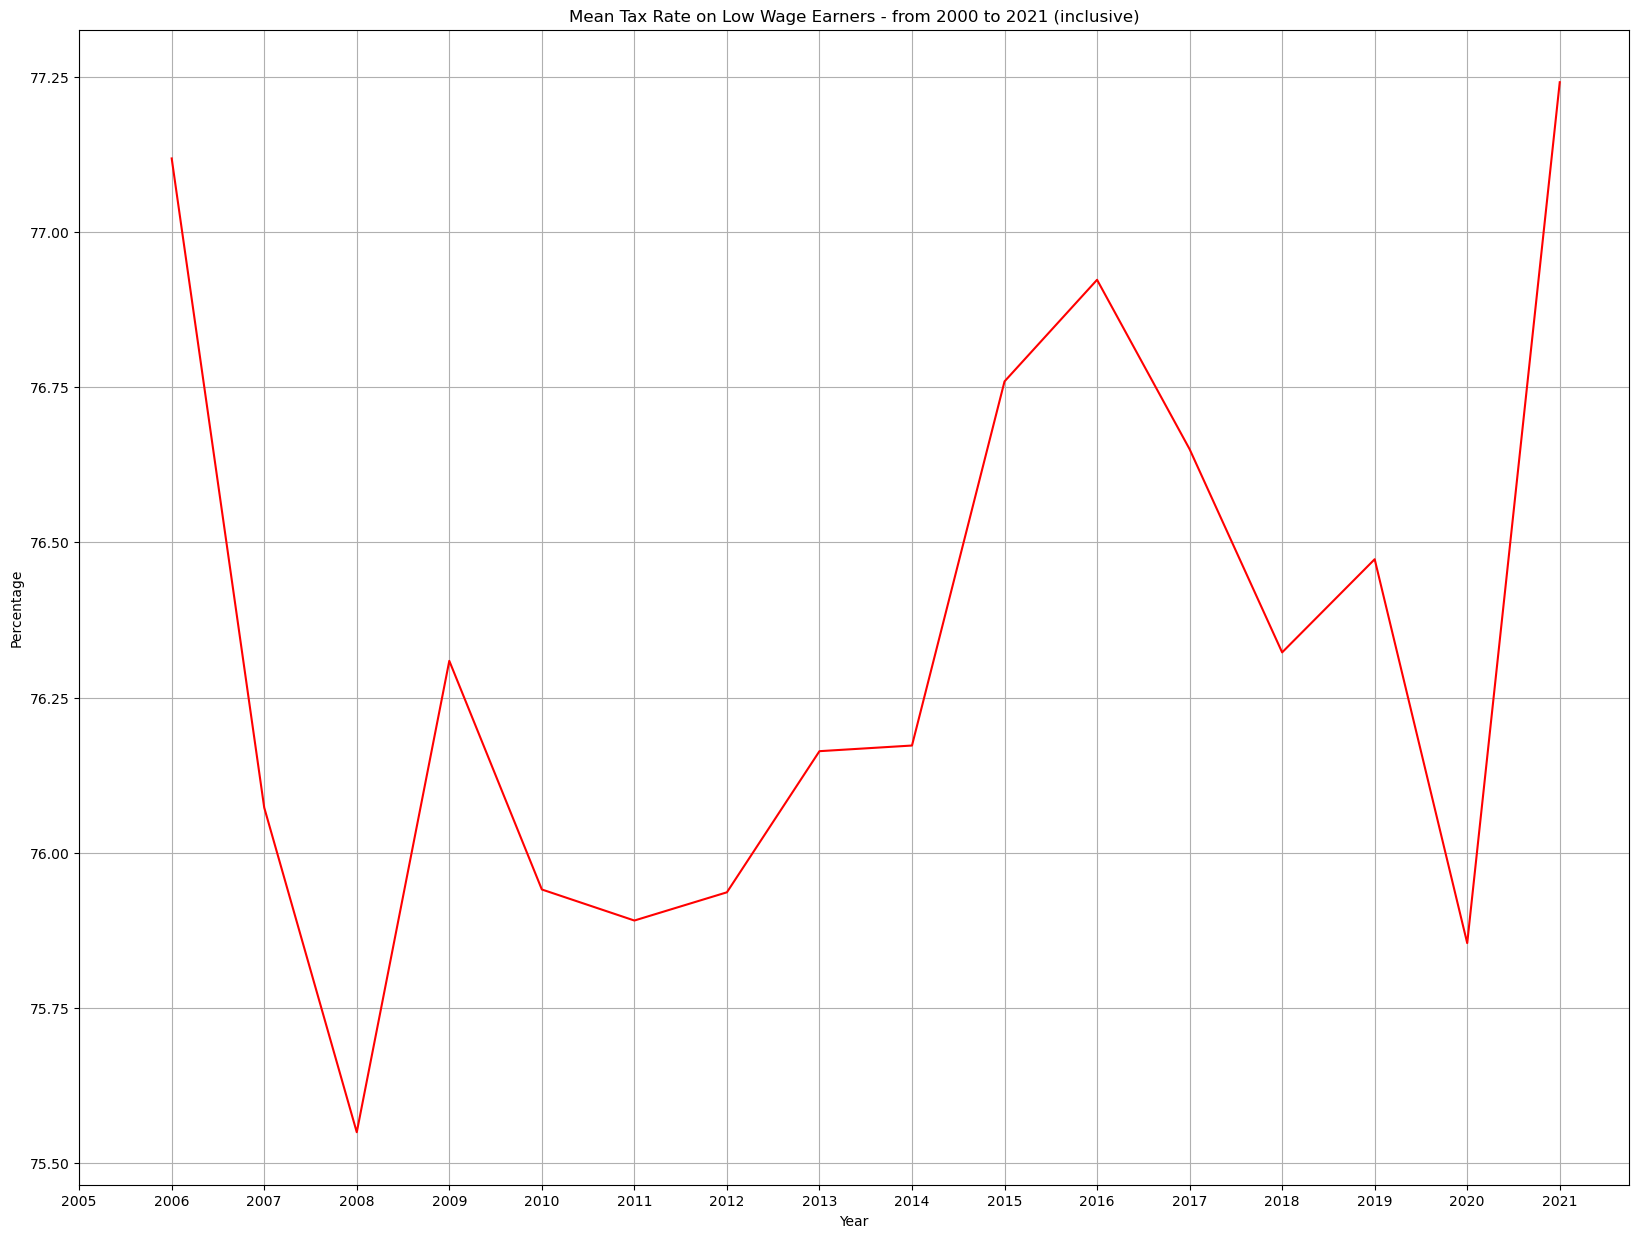

In [8]:
plt.figure(figsize=(20, 15))
plt.plot(df_eu_mean.keys()[1:], df_eu_mean.values[0][1:], color="r")
plt.grid()
plt.xticks(years_xticks)
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title("Mean Tax Rate on Low Wage Earners - from 2000 to 2021 (inclusive)")
plt.show()

As seen in the graph above, tax rate on unemployment dropped significantly for 2008 and 2020

## Comparison of Tax Rate on Low Wage Earners and Labour Productivity

In [9]:
path = "../Datasets/cleaned_Productivity.csv"
df_labour = pd.read_csv(path)
df_labour.rename(columns=lambda x: int(x) if x.isdigit() else x, inplace=True)
df_labour.drop(columns=['mean'], inplace=True)
df_labour.head()

,LOCATION,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AUS,43.813437,45.338482,46.025462,47.089456,46.931496,47.099677,47.342066,47.873036,49.523676,...,51.671243,52.558753,52.780926,54.099648,53.945416,54.561035,54.559641,55.212012,56.214321,56.820351
1,AUT,55.825179,56.533555,57.591558,58.071618,59.181589,60.632340,62.218785,63.814049,63.814456,...,65.645538,66.080679,66.327394,67.267651,67.184974,67.999464,68.309455,68.309868,69.970148,69.634603
2,BEL,63.089170,63.233672,63.667303,64.204011,66.278551,67.287921,67.637137,68.887444,68.464336,...,68.923207,69.517696,70.513657,71.604653,71.674769,71.534022,71.681631,72.259271,74.541737,73.607184
3,BGR,14.861829,15.438275,16.313284,16.783858,17.182034,17.965425,18.618248,19.229785,19.475667,...,22.497211,22.460713,22.607390,23.296069,23.897609,24.130056,24.784139,25.687153,25.775778,26.559335
4,CAN,44.249048,44.960465,45.686833,45.787448,46.167149,47.187987,47.742663,47.802103,47.658733,...,49.335662,50.068609,51.425818,51.340885,51.524774,52.346352,52.543577,52.996192,56.971404,53.969872


In [10]:
df_labour = df_labour[df_labour['LOCATION'].isin(get_alpha_3_list())]
df_labour.reset_index(drop=True, inplace=True)
df_labour.head()

,LOCATION,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AUT,55.825179,56.533555,57.591558,58.071618,59.181589,60.632340,62.218785,63.814049,63.814456,...,65.645538,66.080679,66.327394,67.267651,67.184974,67.999464,68.309455,68.309868,69.970148,69.634603
1,BEL,63.089170,63.233672,63.667303,64.204011,66.278551,67.287921,67.637137,68.887444,68.464336,...,68.923207,69.517696,70.513657,71.604653,71.674769,71.534022,71.681631,72.259271,74.541737,73.607184
2,BGR,14.861829,15.438275,16.313284,16.783858,17.182034,17.965425,18.618248,19.229785,19.475667,...,22.497211,22.460713,22.607390,23.296069,23.897609,24.130056,24.784139,25.687153,25.775778,26.559335
3,CZE,25.998047,27.994158,28.429678,29.901424,31.147574,32.765277,34.781571,36.256014,36.139167,...,36.886973,37.004724,37.432375,39.390083,39.251558,40.595969,41.161265,42.272668,43.289836,43.487932
4,DEU,56.051436,57.459100,57.991792,58.437853,58.970058,59.900695,60.858653,61.577685,61.593702,...,63.093299,63.392823,64.049842,64.376152,65.248665,66.411797,66.549287,67.055996,67.714113,68.303361


In [11]:
# As Labour Productivity dataset uses alpha-3, we need to convert the alpha-2 to alpha3
df_eu_alpha3 = df_eu.copy()
for index, row in df_eu.iterrows():
    df_eu_alpha3.at[index, 'COUNTRY'] = countries.convert_alpha_2_to_3(row['COUNTRY'])
df_eu_alpha3

,COUNTRY,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AUT,83.0,82.9,82.4,81.7,79.9,80.4,74.8,74.8,74.6,74.3,73.9,72.0,72.1,71.7,71.2,70.5,70.1
1,BEL,85.2,84.9,85.3,85.5,92.1,91.0,90.7,91.9,98.1,97.6,96.9,95.8,95.8,93.8,93.0,92.4,91.6
2,CZE,65.7,63.5,59.9,59.6,71.3,71.4,71.7,71.6,71.6,71.7,71.8,72.0,72.3,72.5,72.7,72.8,70.8
3,DEU,75.0,75.6,74.8,74.5,75.2,73.5,73.3,73.3,73.0,73.1,73.1,73.2,73.3,73.2,73.2,73.0,72.8
4,DNK,91.2,90.6,89.5,88.6,88.8,89.2,88.7,89.4,89.4,89.6,89.6,89.8,89.9,89.3,88.4,87.9,87.2
5,EST,64.3,63.5,63.0,62.6,61.9,62.7,63.5,64.3,63.7,63.7,62.9,62.9,62.9,61.5,62.2,62.5,69.3
6,ESP,80.2,80.3,81.5,81.2,80.6,82.6,82.7,82.8,81.7,81.7,81.2,81.1,81.1,81.9,82.0,80.5,82.1
7,FIN,77.8,76.3,74.0,73.1,72.1,72.3,72.3,75.0,75.6,81.7,79.2,78.3,74.4,73.9,73.4,73.1,72.4
8,FRA,81.6,80.8,77.4,77.2,77.2,76.9,77.4,77.3,77.3,77.4,76.5,76.5,75.8,75.1,72.6,72.2,72.7
9,HUN,62.4,68.4,71.6,71.6,72.2,79.9,79.6,79.5,78.8,78.6,78.4,78.1,78.5,78.5,77.1,76.4,73.3


In [12]:
# Get the mean labour productivity
df_labour_mean = df_labour.mean(numeric_only=True, axis=0)
df_labour_mean = df_labour_mean.to_frame().T
df_labour_mean

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,40.567788,41.355559,42.344206,43.293342,44.548287,45.551704,46.767592,47.874305,47.605473,47.046416,...,49.353596,49.746077,50.258789,51.588569,51.838212,52.870522,53.517315,54.254632,55.729785,56.628275


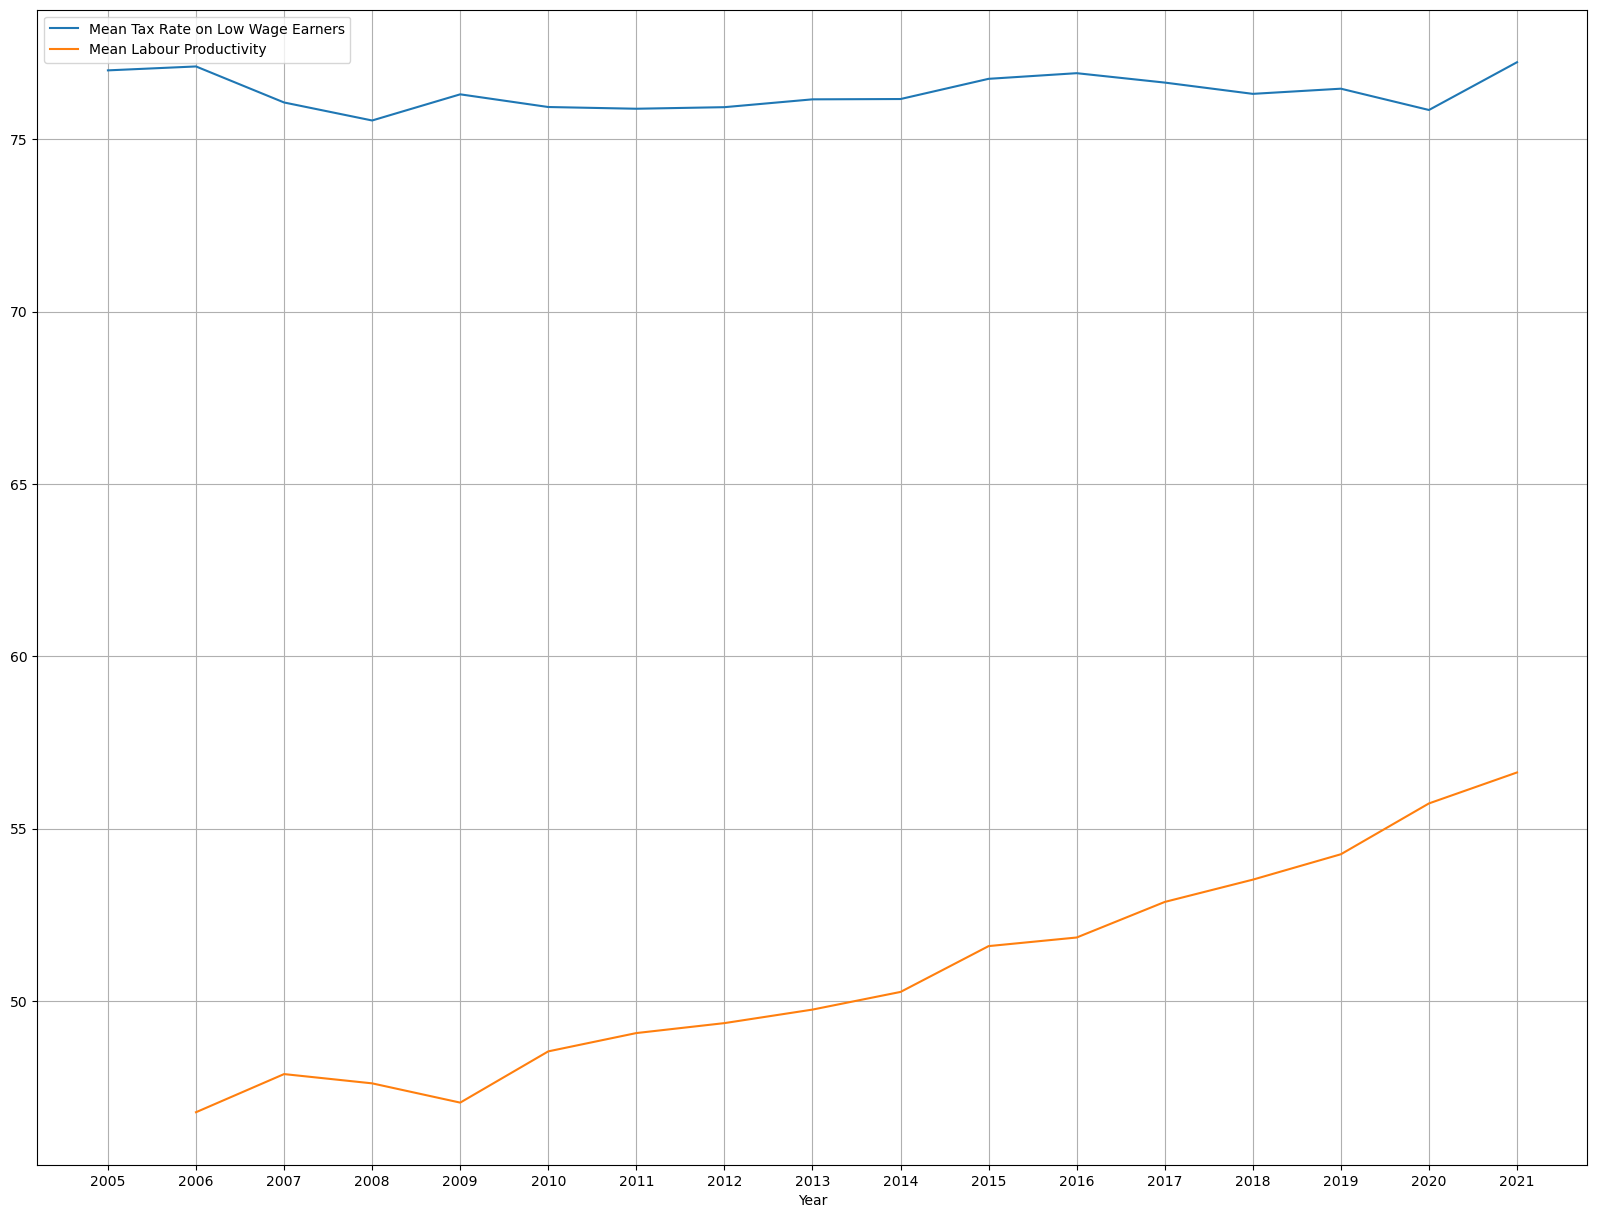

In [13]:
# Plot the mean tax rate and mean labour productivity together
plt.figure(figsize=(20, 15))
plt.plot(years, df_eu_mean.values[0], label="Mean Tax Rate on Low Wage Earners")
plt.plot(df_labour_mean.keys()[6:], df_labour_mean.values[0][6:], label="Mean Labour Productivity")
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.xticks(years_xticks)
plt.show()

In [14]:
# Uneven number of country codes, so get the fewest number of country codes
arr1 = [cd for cd in df_eu_alpha3['COUNTRY']]
arr2 = [cd for cd in df_labour['LOCATION']]
country_codes = arr1 if len(arr1) < len(arr2) else arr2

In [15]:
# Join tables together
df_countries = pd.DataFrame(columns=['Year', 'Country', 'Labour Productivity', 'Tax Rate'])
for i in range(len(country_codes)):
    tmp_dict = {}
    countryCode = country_codes[i]
    for year in years:
        tmp_dict[year] = [df_labour.loc[i, year], df_eu_alpha3.loc[i, year]]
    df_country = pd.DataFrame.from_dict(tmp_dict, orient='index', columns=['Labour Productivity', 'Tax Rate'])
    df_country['Year'] = df_country.index
    df_country['Country'] = countryCode

    df_countries = pd.concat([df_countries, df_country], axis=0)
df_countries.reset_index(drop=True, inplace=True)

In [16]:
# Look at correlation between labour productivity and tax rate on low wage earners
df_correlation = df_countries.groupby(df_countries['Country']).corr(numeric_only=True)
df_correlation

Labour Productivity  Tax Rate
Country                                                   
AUT     Labour Productivity             1.000000 -0.944059
        Tax Rate                       -0.944059  1.000000
BEL     Labour Productivity             1.000000  0.538396
        Tax Rate                        0.538396  1.000000
CZE     Labour Productivity             1.000000  0.713988
        Tax Rate                        0.713988  1.000000
DEU     Labour Productivity             1.000000 -0.727300
        Tax Rate                       -0.727300  1.000000
DNK     Labour Productivity             1.000000 -0.540718
        Tax Rate                       -0.540718  1.000000
ESP     Labour Productivity             1.000000  0.337947
        Tax Rate                        0.337947  1.000000
EST     Labour Productivity             1.000000  0.221418
        Tax Rate                        0.221418  1.000000
FIN     Labour Productivity             1.000000 -0.214204
        Tax Rate                       -0.214204  1.000000
FRA     Labour Productivity             1.000000 -0.796902
        Tax Rate                       -0.796902  1.000000
HUN     Labour Productivity             1.000000  0.468815
        Tax Rate                        0.468815  1.000000
IRL     Labour Productivity             1.000000  0.467911
        Tax Rate                        0.467911  1.000000
ITA     Labour Productivity             1.000000  0.278677
        Tax Rate                        0.278677  1.000000
LTU     Labour Productivity             1.000000  0.566990
        Tax Rate                        0.566990  1.000000
LUX     Labour Productivity             1.000000  0.882444
        Tax Rate                        0.882444  1.000000
LVA     Labour Productivity             1.000000 -0.580392
        Tax Rate                       -0.580392  1.000000
MLT     Labour Productivity             1.000000  0.766685
        Tax Rate                        0.766685  1.000000
NLD     Labour Productivity             1.000000  0.305841
        Tax Rate                        0.305841  1.000000
POL     Labour Productivity             1.000000 -0.763884
        Tax Rate                       -0.763884  1.000000
PRT     Labour Productivity             1.000000 -0.255296
        Tax Rate                       -0.255296  1.000000
SVK     Labour Productivity             1.000000  0.821279
        Tax Rate                        0.821279  1.000000
SVN     Labour Productivity             1.000000 -0.118406
        Tax Rate                       -0.118406  1.000000
SWE     Labour Productivity             1.000000 -0.334028
        Tax Rate                       -0.334028  1.000000

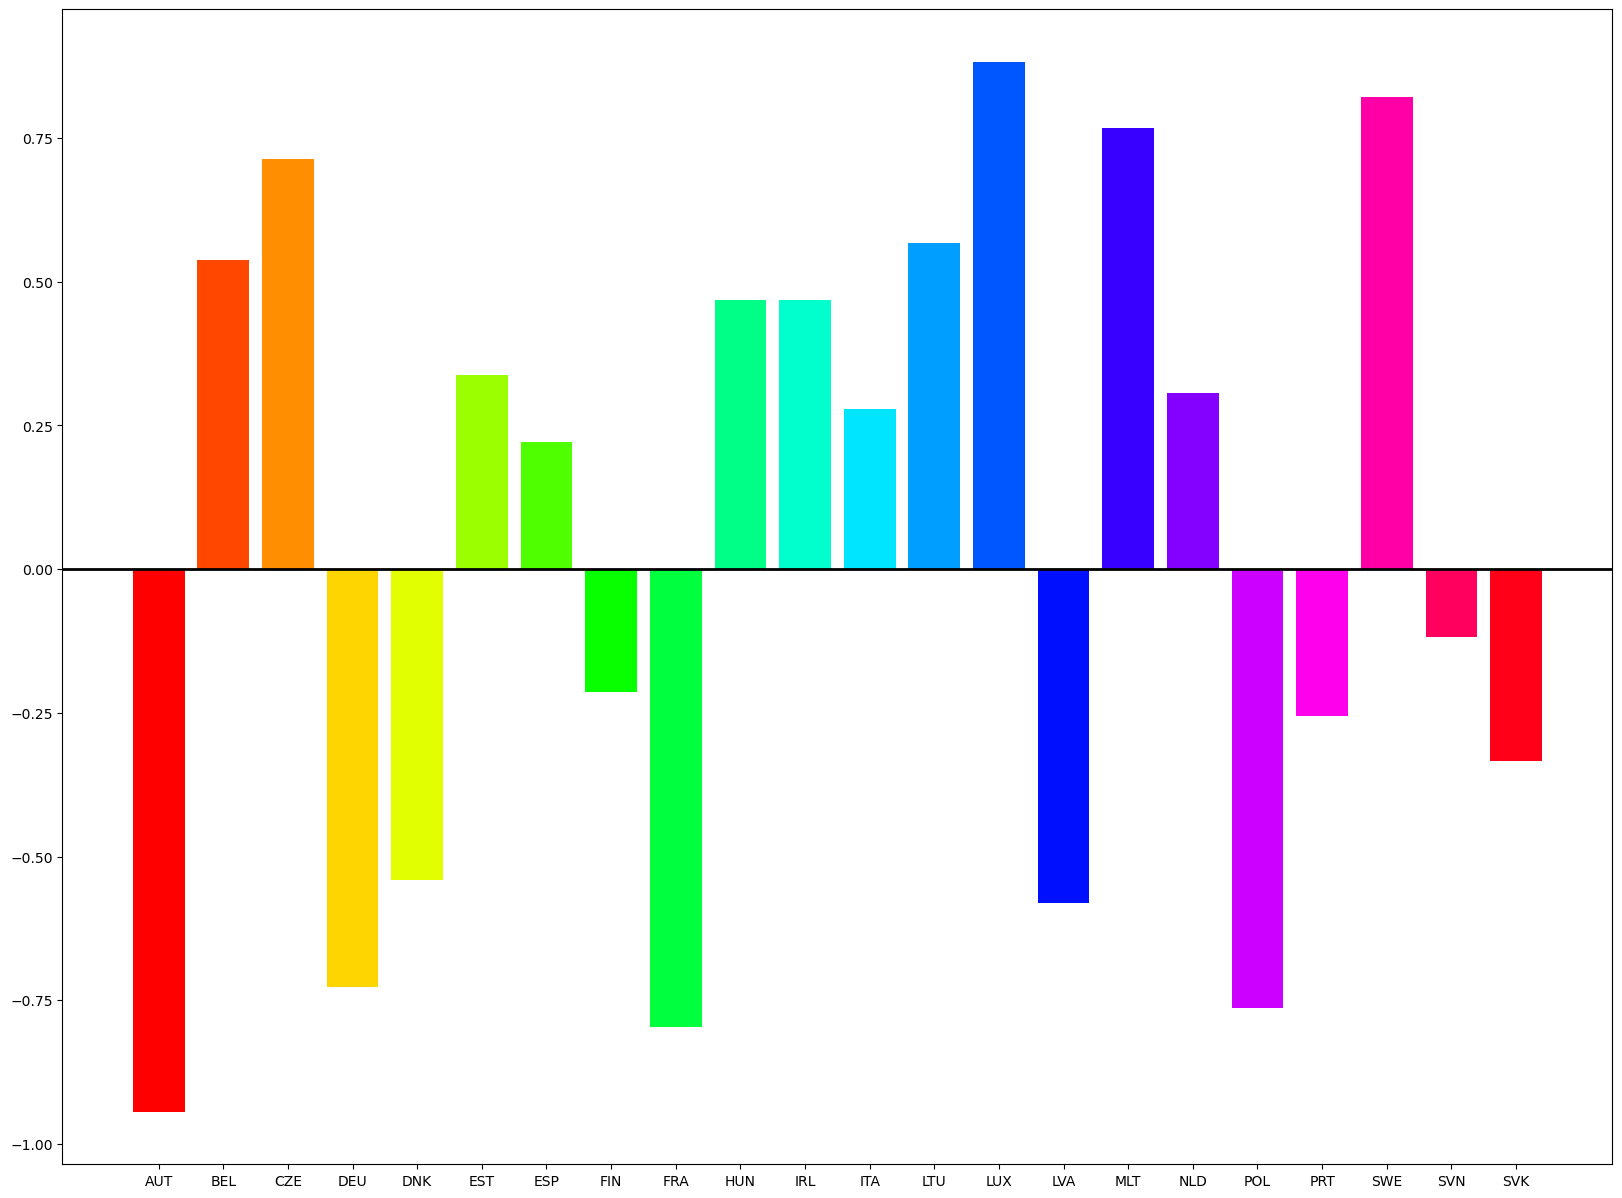

In [17]:
# Plot correlations, x axis = countries, y axis = correlation between mean tax rate and mean labour productivity
plt.figure(figsize=(20, 15))

# Get tax rate and labour productivity correlation values
colors = plt.cm.hsv(np.linspace(0, 1, len(country_codes)))
correlations = df_correlation.values[1::2][:, 0]
plt.bar(df_countries['Country'].unique(), correlations, color=colors)
plt.axhline(y=0, color='black', linewidth=2)
plt.show()


In [18]:
# Look at correlation between mean labour productivity and mean tax rate on low wage earners
df_labour_mean.corrwith(df_eu_mean, axis=1)

0    0.168125
dtype: float64

In [19]:
# REFERENCE: https://www.statology.org/granger-causality-test-in-python/
# Use Granger Causality tests to compare the means
df_mean = pd.DataFrame(columns=['labour_productivity', 'tax_rate'])
df_mean['labour_productivity'] = df_labour_mean.values[0][6:]
df_mean['tax_rate'] = df_eu_mean.values[0][1:]
results = grangercausalitytests(df_mean, maxlag=2, verbose=False)

# If the p-value is less than 0.05, then the null hypothesis is rejected and there is a Granger Causality
if results.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('Tax Rate is a predictor variable of Labour Productivity')

results = grangercausalitytests(df_mean[['tax_rate', 'labour_productivity']], maxlag=2, verbose=False)

# If the p-value is less than 0.05, then the null hypothesis is rejected and there is a Granger Causality
if results.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('Labour Productivity is a predictor variable of Tax Rate:', results.get(1)[0]['ssr_ftest'][1])

Labour Productivity is a predictor variable of Tax Rate: 0.028260250943025342
